In [2]:
import pandas as pd
import numpy as np
import datetime
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from nltk import ngrams
from nltk.probability import FreqDist
from langdetect import detect
import matplotlib.pyplot as plt; plt.rcdefaults()

In [3]:
#to show the full texts in the output window
pd.set_option('display.max_colwidth', -1)

In [4]:
#input gold price dataset and convert it into time series data
rawPriceData=pd.read_csv('/Users/Mandy/Study/SpringBoard/Capstone 2/GoldPriceData-Raw.csv')
rawPriceData['Date'] = pd.to_datetime(rawPriceData['Date'])
rawPriceData.set_index(rawPriceData['Date'],inplace=True)

In [5]:
# filling weekend/public holiday missing data by taking average.
priceData=rawPriceData.resample('D').interpolate()
priceData=priceData['Price']

In [6]:
#input tweet dataset
rawTweetData=pd.read_csv('/Users/Mandy/Study/SpringBoard/Capstone 2/GoldTweetDataWorkBook.csv',encoding='latin1')
print(rawTweetData.head())


      date  score  language  \
0  3/31/18  0     NaN         
1  3/31/18  1     NaN         
2  3/31/18  0     NaN         
3  3/31/18  0     NaN         
4  3/31/18 -1     NaN         

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           text  
0  à¸à¸±à¸à¸à¸µà¸à¸µà¹à¸à¹à¸²à¸§à¸à

In [7]:
#detect non-English tweets and delete those rows
def findLanguage(row):
    try:
        return detect(row)
    except:
        return "empty"

rawTweetData.language = rawTweetData.text.apply(findLanguage)
rawTweetData=rawTweetData[rawTweetData.language=='en']
rawTweetData=rawTweetData.loc[:,['date','score','language','text']]
print(rawTweetData.head())

      date  score language  \
1  3/31/18  1      en        
2  3/31/18  0      en        
3  3/31/18  0      en        
4  3/31/18 -1      en        
5  3/31/18  1      en        

                                                                                                                                                                                                                   text  
1  President Trumpâs infrastructure proposal will build upon the success his Administration has already had in strengthening the American economy . More: http:// 45.wh.gov/qoJfmc pic.twitter.com/EGT8Yyu16t          
2  Glad that @ShekharGupta has pointed out ânever in our economic history                                                                                                                                              
3  feminist: a person who believes in the social political and economic equality of sexes pic.twitter.com/pFJeLORsxg                                                 

In [57]:
#replace special characters, such as URLs, usernames, hashtags, pictures with"URL","USER","HASHTAG","PICTURE"
#also remove all the special characters
for row in rawTweetData.index:
    eachTweet=rawTweetData.text[row]
    eachTweet_url=re.sub(r"https:// \S+","URL",eachTweet)
    eachTweet_pic=re.sub(r"pic.\S+","PICTURE",eachTweet_url)
    eachTweet_user=re.sub(r"@\S+","USER",eachTweet_pic)
    eachTweet_hashtag=re.sub(r"#\S+","HASHTAG",eachTweet_user)
    eachTweet_spechar=re.sub("[^A-Za-z0-9]+"," ",eachTweet_hashtag).lower()
    rawTweetData.set_value(row,'Tweet',eachTweet_spechar)
print(rawTweetData.head())

      date  score language  \
1  3/31/18  1      en        
2  3/31/18  0      en        
3  3/31/18  0      en        
4  3/31/18 -1      en        
5  3/31/18  1      en        

                                                                                                                                                                                                                   text  \
1  President Trumpâs infrastructure proposal will build upon the success his Administration has already had in strengthening the American economy . More: http:// 45.wh.gov/qoJfmc pic.twitter.com/EGT8Yyu16t           
2  Glad that @ShekharGupta has pointed out ânever in our economic history                                                                                                                                               
3  feminist: a person who believes in the social political and economic equality of sexes pic.twitter.com/pFJeLORsxg                                              

In [58]:
#Split tweet text word by word (tokenize)
tokenizedTweet = rawTweetData.apply(lambda row: word_tokenize(row['Tweet']), axis=1)
print(tokenizedTweet.head())

1    [president, trump, s, infrastructure, proposal, will, build, upon, the, success, his, administration, has, already, had, in, strengthening, the, american, economy, more, http, 45, wh, gov, qojfmc, picture]                                          
2    [glad, that, user, has, pointed, out, never, in, our, economic, history]                                                                                                                                                                               
3    [feminist, a, person, who, believes, in, the, social, political, and, economic, equality, of, sexes, picture]                                                                                                                                          
4    [is, the, gig, economy, making, freelance, clients, cheap, http, on, forbes, com, 6017dvlvf, picture]                                                                                                                                       

In [59]:
#remove stopwords( words that don't have any positive/negative meanings)
filteredTweet = tokenizedTweet.apply(lambda x: [word for word in x if word not in stopwords.words('english')])
print(filteredTweet.head())

1    [president, trump, infrastructure, proposal, build, upon, success, administration, already, strengthening, american, economy, http, 45, wh, gov, qojfmc, picture]
2    [glad, user, pointed, never, economic, history]                                                                                                                  
3    [feminist, person, believes, social, political, economic, equality, sexes, picture]                                                                              
4    [gig, economy, making, freelance, clients, cheap, http, forbes, com, 6017dvlvf, picture]                                                                         
5    [diaspora, culture, thinking, know, better, people, stayed, home, combined, thinking, go, back, home, change, culture, economy, little, snowflake, got, visa]    
dtype: object


In [60]:
#Tweet data after all the pre-processing steps
tweetData=rawTweetData.loc[:,['date','score']]
tweetData=pd.concat([tweetData, filteredTweet], axis=1)
tweetData.columns=['date','score','tweet']
print(tweetData.head())

      date  score  \
1  3/31/18  1       
2  3/31/18  0       
3  3/31/18  0       
4  3/31/18 -1       
5  3/31/18  1       

                                                                                                                                                               tweet  
1  [president, trump, infrastructure, proposal, build, upon, success, administration, already, strengthening, american, economy, http, 45, wh, gov, qojfmc, picture]  
2  [glad, user, pointed, never, economic, history]                                                                                                                    
3  [feminist, person, believes, social, political, economic, equality, sexes, picture]                                                                                
4  [gig, economy, making, freelance, clients, cheap, http, forbes, com, 6017dvlvf, picture]                                                                           
5  [diaspora, culture, thinking, know,

In [61]:
#function to combine every words from all the tweets into a word library
def get_words_in_tweets(tweets):
    all_words = []
    for words in tweets:
        all_words.extend(words)
    return all_words

#call the function
word_list=get_words_in_tweets(filteredTweet)

In [62]:
# a distribution table of words and their corresponding frequencies
word_features=FreqDist(word for word in word_list)
word_freq=[word_features[w] for w in word_features]
target_word=list(word_features.keys())
word_freq=pd.DataFrame(word_freq)
target_word=pd.DataFrame(target_word)
word_freq_dist=pd.concat([target_word,word_freq],axis=1)
word_freq_dist.columns=['target_word','frequency']
word_freq_dist=word_freq_dist.sort_values('frequency',ascending=False)
print(word_freq_dist.head())

    target_word  frequency
11   economy     10413    
144  hashtag     8414     
19   user        5525     
22   economic    5109     
17   picture     3132     


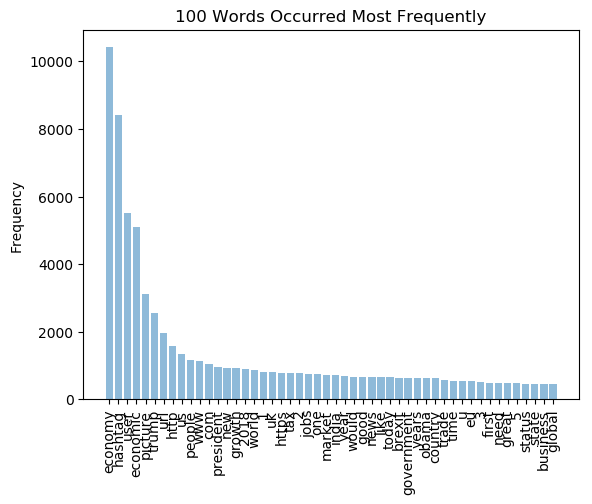

In [63]:
# draw a bar chart to show the frequency of the 100 most common words
x_word = word_freq_dist.iloc[0:50,0]
y_pos = np.arange(len(x_word))
y_freq = word_freq_dist.iloc[0:50,1]

plt.bar(y_pos, y_freq, align='center', alpha=0.5)
plt.xticks(y_pos, x_word)
plt.ylabel('Frequency')
plt.title('100 Words Occurred Most Frequently')
plt.xticks(rotation=90)
 
plt.show()

In [64]:
#function to extract efficient features that helps classify positive/negative/neutral tweets. 
def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
    return features
